In [99]:
# %load_ext autoreload
# %autoreload 2
# !pip install torchsummary

 # Imports, Constants, Classes

In [100]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import robust_scale
from torch.utils.data import DataLoader, TensorDataset
# from torchsummary import summary
from tqdm.notebook import tqdm

In [101]:
DATA_DIR = Path("/kaggle/input/enf-datd-frequency-features")

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [102]:
# Use CUDA if a GPU is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Using device", device)

Using device cuda:0


In [103]:
# Hyperparameters
NUM_EPOCHS = 200
BATCH_SIZE = 32
NOMINAL_ENF = 50.0
TEST_SIZE = 0.2

In [104]:
class OneDCNN(nn.Module):
    def __init__(self):
        super(OneDCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=75, kernel_size=130, stride=1) # Convolutional Layer
        self.pool = nn.MaxPool1d(kernel_size=491-80-130+1)  # Max-Pooling Layer: Adjust kernel size to pool to (75, 1)
        
        self.fc1 = nn.Linear(75, 128) # Dense Layer to go from (75) to (128)
        self.fc2 = nn.Linear(128, 2) # Output Layer to go from (128) to (10) or 2 for binary classification
        
    def forward(self, x):
        # Apply convolutional layer with ReLU activation
        x = F.relu(self.conv1(x))
        
        # Apply max pooling
        x = self.pool(x) # Shape after pooling: (batch_size, 75, 1)
        
        # Transpose to get (batch_size, 1, 75)
        x = x.squeeze(-1)  # Squeeze to remove the last dimension -> (batch_size, 75)
        x = x.unsqueeze(1)  # Add a new dimension to get (batch_size, 1, 75)
        
        # Apply fully connected layer to get (batch_size, 1, 128)
        x = F.relu(self.fc1(x.squeeze(1)))  # Remove dimension for dense layer and apply ReLU
        x = x.unsqueeze(1)  # Add back the dimension -> (batch_size, 1, 128)
        
        # Apply final output layer to get (batch_size, 1, 2)
        x = self.fc2(x.squeeze(1))  # Remove dimension, apply final dense layer
        
        # Apply softmax to get class probabilities
        x = F.softmax(x, dim=1)  # Softmax over the class dimension (dim=1)
        
        return x

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


 # Initializing

In [105]:
# Load & Clip (no need to cocncatenate further)
# dsets = ["Synthetic", "WHU_ref", "Carioca1", "Carioca2"]
dsets = ["Carioca1", "Carioca2"]
dset_id_dict = {dset: i for i, dset in enumerate(dsets)}
ids = list(range(len(dsets)))
files = sorted(sum([list((DATA_DIR / dset).glob("*.npy")) for dset in dsets], list()))

labels = np.array([int("tamp" in file.stem) for file in files])
data = np.stack([np.load(file)[40:-40] for file in files])
dset = np.array([dset_id_dict[file.parts[-2]] for file in files])
stratify = np.stack((labels, dset), axis=-1)
# data shape: (n_samples, n_features)
print(data.shape)

# Pad sequences with the nominal ENF value
# data = np.array([np.pad(seq, (0, 2861 - len(seq)), "constant", constant_values=NOMINAL_ENF) for seq in data])

# Normalize the data for each sample
data = robust_scale(data, axis=1)

# Add channel dimension
data = data[:, np.newaxis, :]
# input_size = (1, data.shape[1])

# Split the data into training, validation, and test sets
X_train, X_test, stratify_train, stratify_test = train_test_split(
    data, stratify, test_size=TEST_SIZE, random_state=0, stratify=stratify
)

y_train = stratify_train[:, 0]
y_test = stratify_test[:, 0]
dset_test = stratify_test[:, 1]

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=TEST_SIZE, random_state=0, stratify=stratify_train
)

# Convert data to tensors
X_train_tensor = torch.Tensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_val_tensor = torch.Tensor(X_val).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
X_test_tensor = torch.Tensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check the distribution of the classes
unique, counts = np.unique(y_train_tensor.cpu(), return_counts=True)
class_distribution = dict(zip(unique, counts))
print(f"y_train distribution: {class_distribution}")

unique, counts = np.unique(y_val_tensor.cpu(), return_counts=True)
class_distribution = dict(zip(unique, counts))
print(f"y_val distribution: {class_distribution}")

unique, counts = np.unique(y_test_tensor.cpu(), return_counts=True)
class_distribution = dict(zip(unique, counts))
print(f"y_test distribution: {class_distribution}")

(4000, 411)
y_train distribution: {0: 1280, 1: 1280}
y_val distribution: {0: 320, 1: 320}
y_test distribution: {0: 400, 1: 400}


In [106]:
# Separate Test Loaders
X_test_dsets = [X_test[dset_test == i] for i in ids]
y_test_dsets = [y_test[dset_test == i] for i in ids]

# Convert to tensors and move to device
X_test_tensor_dsets = [torch.tensor(X_test_dset, dtype=torch.float32).to(device) for X_test_dset in X_test_dsets]
y_test_tensor_dsets = [torch.LongTensor(y_test_dset).to(device) for y_test_dset in y_test_dsets]

###.....................Create TensorDatasets for spatial and temporal inputs.....................###
test_dataset_dsets = [TensorDataset(X_test_tensor_dset, y_test_tensor_dset) for X_test_tensor_dset, y_test_tensor_dset in zip(X_test_tensor_dsets, y_test_tensor_dsets)]

# Data loaders
test_loader_dsets = [DataLoader(test_dataset_dset, batch_size=BATCH_SIZE, shuffle=False) for test_dataset_dset in test_dataset_dsets]

In [107]:
# Plot a sample from the data
# plt.figure(figsize=(10, 2))
# plt.plot(data[0])
# plt.title("Sample Data Plot")
# plt.show()


In [108]:
# # Print a single batch from the DataLoader
# inputs, labels = next(iter(train_loader))
# print(f"Input batch shape: {inputs.shape}")
# print(f"Labels batch: {labels}")


In [109]:
# Display model summary
# summary(model, input_size=input_size)
print(train_loader.dataset.tensors[0].shape)

torch.Size([2560, 1, 411])


# Training

In [110]:
# Training and validation loop
LEARNING_RATE = 0.002

# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Initialize the model
model = OneDCNN().to(device)

# Initialize EarlyStopping object
# early_stopping = EarlyStopping(patience=10, min_delta=0.001)

# BEGIN

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in (pbar:=tqdm(range(NUM_EPOCHS), desc="Training Progress")):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    
    pbar.set_postfix_str(f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, TA: {train_accuracy:.4f}, VA: {val_accuracy:.4f}")
    if (epoch + 1) % 10 == 0 or epoch == 0:
        tqdm.write(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # # Check early stopping condition
    # early_stopping(val_loss)
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break

Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200, Train Loss: 0.6826, Val Loss: 0.6848, Train Accuracy: 0.4848, Val Accuracy: 0.4750
Epoch 10/200, Train Loss: 0.6826, Val Loss: 0.6848, Train Accuracy: 0.4848, Val Accuracy: 0.4750
Epoch 20/200, Train Loss: 0.6826, Val Loss: 0.6848, Train Accuracy: 0.4848, Val Accuracy: 0.4750
Epoch 30/200, Train Loss: 0.6826, Val Loss: 0.6848, Train Accuracy: 0.4848, Val Accuracy: 0.4750
Epoch 40/200, Train Loss: 0.6826, Val Loss: 0.6848, Train Accuracy: 0.4848, Val Accuracy: 0.4750
Epoch 50/200, Train Loss: 0.6826, Val Loss: 0.6848, Train Accuracy: 0.4848, Val Accuracy: 0.4750
Epoch 60/200, Train Loss: 0.6826, Val Loss: 0.6848, Train Accuracy: 0.4848, Val Accuracy: 0.4750
Epoch 70/200, Train Loss: 0.6826, Val Loss: 0.6848, Train Accuracy: 0.4848, Val Accuracy: 0.4750
Epoch 80/200, Train Loss: 0.6826, Val Loss: 0.6848, Train Accuracy: 0.4848, Val Accuracy: 0.4750
Epoch 90/200, Train Loss: 0.6826, Val Loss: 0.6848, Train Accuracy: 0.4848, Val Accuracy: 0.4750
Epoch 100/200, Train Loss: 0.68

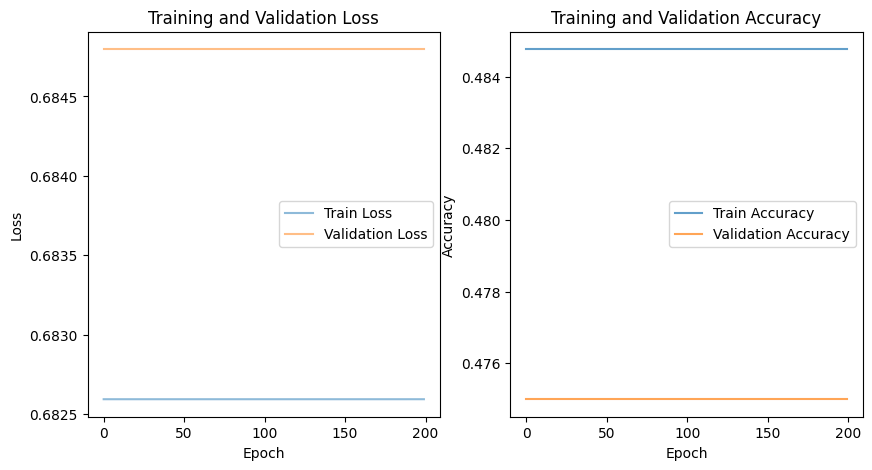

Model saved successfully!


<Figure size 640x480 with 0 Axes>

In [111]:
# Plot the training and validation losses and accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", alpha=.5)
plt.plot(val_losses, label="Validation Loss", alpha=.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", alpha=.7)
plt.plot(val_accuracies, label="Validation Accuracy", alpha=.7)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.show()
plt.savefig("cnn_loss_accuracy.pdf", dpi=300)

# Save the model
torch.save(model.state_dict(), "onedcnn_model.pth")
print("Model saved successfully!")

# Testing

Alldata
Confusion Matrix:
[[117 283]
 [120 280]]
Test Accuracy: 0.4963


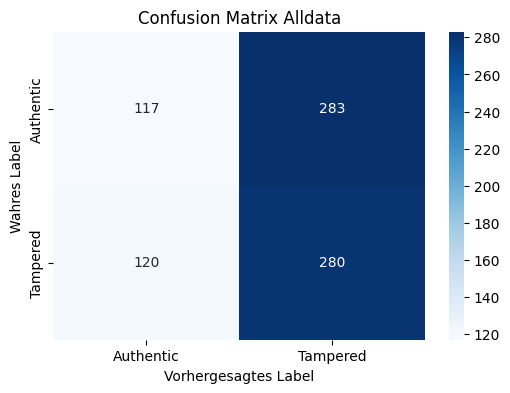

Carioca1
Confusion Matrix:
[[ 56 144]
 [ 52 148]]
Test Accuracy: 0.5100


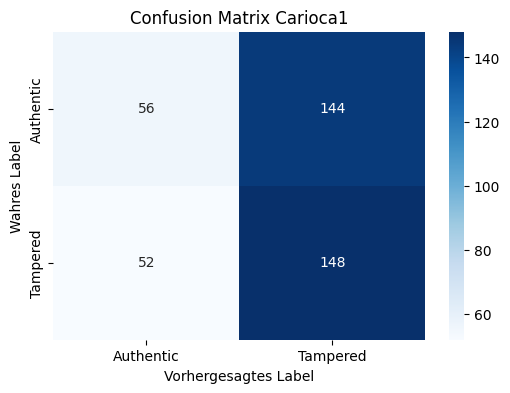

Carioca2
Confusion Matrix:
[[ 61 139]
 [ 68 132]]
Test Accuracy: 0.4825


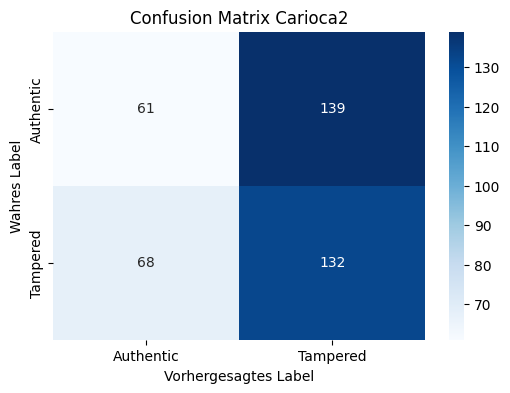

In [112]:
# Testing phase
model.eval()

for name, loader in zip(["Alldata"]+dsets, [test_loader] + test_loader_dsets):
    print(name)
    test_loss = 0.0

    predictions = []
    labels = []
    with torch.no_grad():
        for inputs, _labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, _labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu())
            labels.extend(_labels.cpu())

    cm = confusion_matrix(labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    accuracy = accuracy_score(labels, predictions)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".0f",
        cmap="Blues",
        xticklabels=["Authentic", "Tampered"],
        yticklabels=["Authentic", "Tampered"],
    )
    plt.xlabel("Vorhergesagtes Label")
    plt.ylabel("Wahres Label")
    plt.title(f"Confusion Matrix {name}")
    plt.savefig(f"cm_cnn_{name}.pdf", dpi=300)
    plt.show()
